In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import scanpy as sc

In [20]:
from pca import LowRank, n2s_low_rank

Paul dataset with PC regression and PCA.

In [40]:
paul = sc.read('/Users/josh/src/noise2self-single-cell/data/paul/paul.h5ad')

Optimal rank: 16


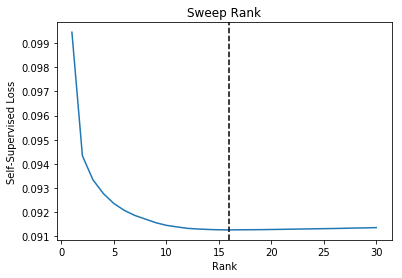

In [43]:
denoised_adata = n2s_low_rank(paul, regression=True)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


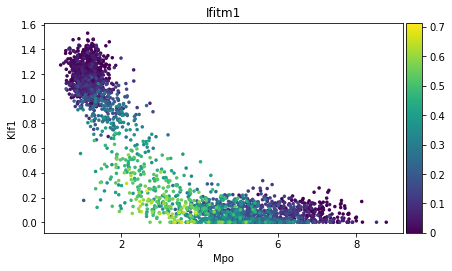

In [44]:
sc.pp.normalize_per_cell(denoised_adata)
sc.pp.sqrt(denoised_adata)
sc.pl.scatter(denoised_adata, x='Mpo', y='Klf1', color='Ifitm1')

Optimal rank: 12


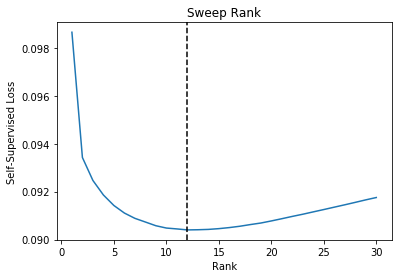

In [45]:
denoised_adata_pca = n2s_low_rank(paul, regression=False)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


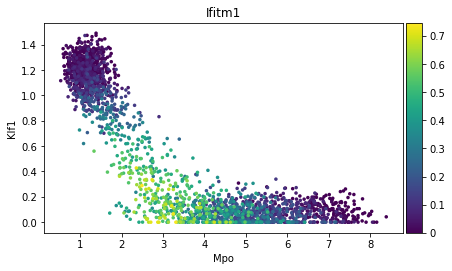

In [8]:
sc.pp.normalize_per_cell(denoised_adata_pca)
sc.pp.sqrt(denoised_adata_pca)
sc.pl.scatter(denoised_adata_pca, x='Mpo', y='Klf1', color='Ifitm1')

In [9]:
denoised_adata.raw = denoised_adata

In [10]:
sc.pp.scale(denoised_adata)

/Users/josh/anaconda3/envs/pytorch/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:1043: RuntimeWarning: invalid value encountered in true_divide
  X /= scale


Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


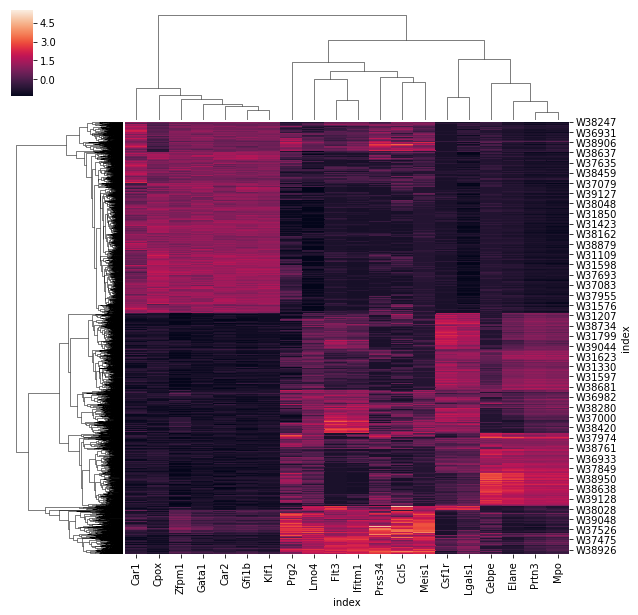

In [11]:
marker_genes = ['Ccl5', 'Prg2', 'Prss34', 'Meis1', 'Cebpe', 'Csf1r', 'Lgals1', 'Elane', 'Prtn3', 'Mpo',
                'Flt3', 'Ifitm1', 'Lmo4', 'Gata1', 'Gfi1b', 'Car1', 'Car2', 'Klf1', 'Zfpm1', 'Cpox']
clustergrid = sc.pl.clustermap(denoised_adata[:,marker_genes], use_raw = False, show = False)

## Plot vs raw in same order

In [12]:
denoised_inset = denoised_adata[:,marker_genes][clustergrid.dendrogram_row.reordered_ind,:][:, clustergrid.dendrogram_col.reordered_ind]

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


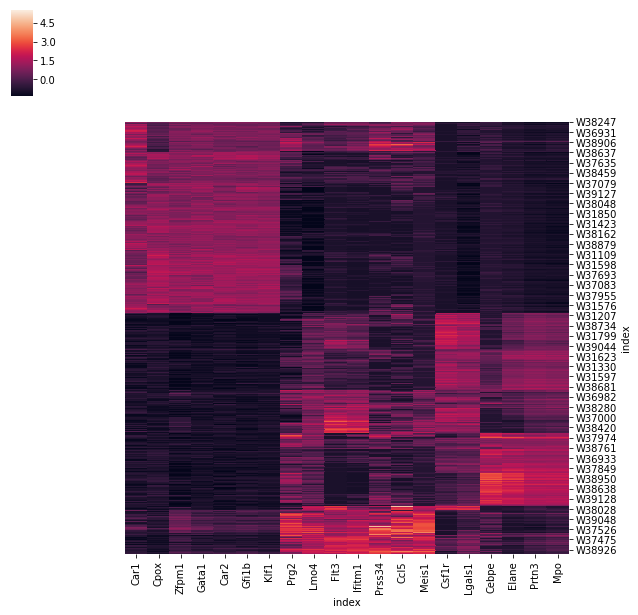

In [13]:
sc.pl.clustermap(denoised_inset, use_raw = False, row_cluster = False, col_cluster = False)

In [14]:
paul.raw = paul
sc.pp.normalize_per_cell(paul, counts_per_cell_after=1e4)
sc.pp.sqrt(paul)
sc.pp.scale(paul)

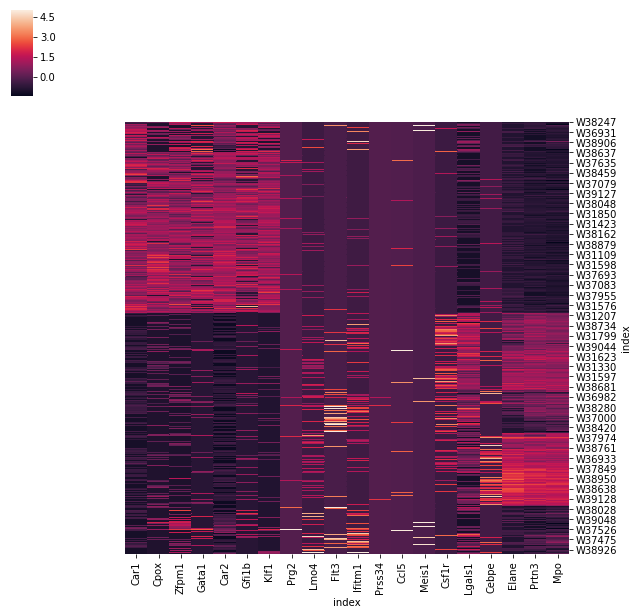

In [15]:
paul_inset = denoised_inset = paul[:,marker_genes][clustergrid.dendrogram_row.reordered_ind,:][:, clustergrid.dendrogram_col.reordered_ind]
sc.pl.clustermap(paul_inset, use_raw = False, row_cluster = False, col_cluster = False, vmax = 5)

# HCA

In [16]:
hca = sc.read('/Users/josh/src/noise2self-single-cell/data/hca/hca_marrow_deep.h5ad')
hca_down = sc.pp.downsample_counts(hca, 2000, replace = False, copy = True)

Optimal rank: 13


Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'int64' is maintained. 


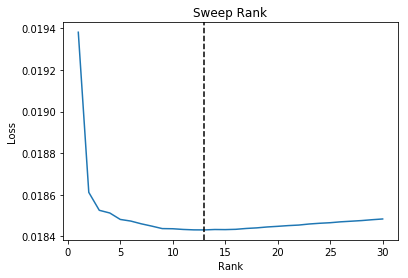

In [17]:
denoised_hca = n2s_low_rank(hca_down, regression=True)

Optimal rank: 9


Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'int64' is maintained. 


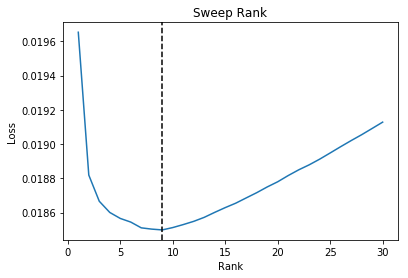

In [18]:
denoised_hca_pca = n2s_low_rank(hca_down, regression=False)

In [19]:
from scipy.sparse import issparse
def cor(X, Y):
    if issparse(X):
        X = np.array(X.todense())
    if issparse(Y):
        Y = np.array(Y.todense())
    return np.corrcoef(X.ravel(), Y.ravel())[0, 1]

In [27]:
print("Original correlation: ", cor(hca_down.X.sqrt(), hca.X.sqrt()))

Original correlation:  0.7802032108454697


In [29]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca.X), hca.X.sqrt()))

Denoised correlation:  0.897139371747421


In [30]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca_pca.X), hca.X.sqrt()))

Denoised correlation:  0.8967855924920433


# Stability of PC Regression

In [11]:
paul = sc.datasets.paul15()

... 100%

... storing 'paul15_clusters' as categorical


Optimal rank: 16


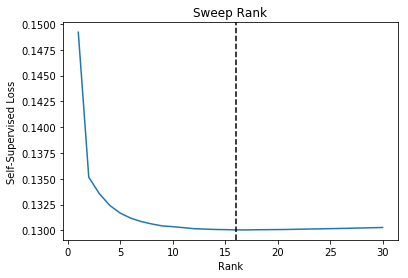

In [37]:
denoised_adata = n2s_low_rank(paul, regression=True)

In [ ]:
V = np.random.randn(500,5)
W = np.random.randn(5, 200)
L = (V.dot(W))
L = L/(np.max(L))*3

X1 = np.random.randn(V)
X2 = np.random.randn(W)

In [30]:
X = paul.X

X = X.astype(np.int)
np.random.seed(0)
X1 = np.random.binomial(X, 0.5)
X2 = X - X1

In [31]:
x = np.sqrt(denoised_adata.X)

In [36]:
rank_range = np.arange(1, 25, 2)
diff_from_opt = np.zeros(len(rank_range))
for i, r in enumerate(rank_range):
    model = LowRank(r, regression=True)
    y = model.fit_transform(X1, X2)
    diff = ((np.sqrt(y) - x)**2).mean()
    diff_from_opt[i] = diff
    print(r, ': ', diff)

1 :  0.02056164118959706
3 :  0.004906760324514881
5 :  0.0027534155659403267
7 :  0.0017187939439523943
9 :  0.001070357292043151
11 :  0.0006869342945542818
13 :  0.0003826122756931465
15 :  0.00018943817572063054
17 :  0.0002420149088303624
19 :  0.00037286476600429703
21 :  0.0005304636046424481
23 :  0.0006268238246982786


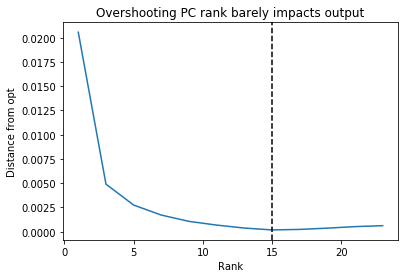

In [46]:
plt.plot(rank_range, diff_from_opt)
plt.xlabel("Rank")
plt.ylabel("Distance from opt")
plt.title("Overshooting PC rank barely impacts output")
plt.axvline(rank_range[np.argmin(diff_from_opt)], color='k', linestyle='--')